<a href="https://colab.research.google.com/github/Abishethvarman/ChatGPT-Education/blob/main/ChatGPT_Education_RNN_LSTM_3C_250E%2BGloVe_44000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of tweets on education in ChatGPT
## Bi-directional LSTM with RNN Architecture for 3 classes (250 iteration) + GloVe
Neutral - 0
Positive - 1
Negative - 2


---


The data set : https://drive.google.com/file/d/1Lw3UNB5FCUQqm1Otk7EYBvpDyIHM7ALi/view?usp=drive_link

---


Orgin: https://www.kaggle.com/datasets/nutrientaxis/chatgpt-and-education-tweets-dataset?select=ChatGPT_Education_Tweets_Dataset.csv

In [1]:
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.8 MB/s eta 0:00:00


In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-08-31 17:59:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-08-31 17:59:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-08-31 17:59:31--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [3]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk import download
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [6]:
%cd /mydrive/dataset/

/content/gdrive/My Drive/dataset


In [7]:
df_data = pd.read_csv("ChatGPT_Education_Tweets_Dataset.csv")

In [8]:
#labels to integers
df_data['sentiment'] = df_data['sentiment'].replace({'neutral': 0, 'positive': 1, 'negative': 2})

In [9]:
target_samples = 44000
neutral_tweets = df_data[df_data['sentiment'] == 0].sample(n=target_samples, random_state=42)
positive_tweets = df_data[df_data['sentiment'] == 1].sample(n=target_samples, random_state=42)
negative_tweets = df_data[df_data['sentiment'] == 2].sample(n=target_samples, random_state=42)

df_adjusted = pd.concat([neutral_tweets, positive_tweets, negative_tweets], ignore_index=True)
df_adjusted = df_adjusted.sample(frac=1, random_state=42)

In [10]:
print("Number of neutral tweets:", df_adjusted[df_adjusted['sentiment'] == 0].shape[0])
print("Number of positive tweets:", df_adjusted[df_adjusted['sentiment'] == 1].shape[0])
print("Number of negative tweets:", df_adjusted[df_adjusted['sentiment'] == 2].shape[0])

Number of neutral tweets: 44000
Number of positive tweets: 44000
Number of negative tweets: 44000


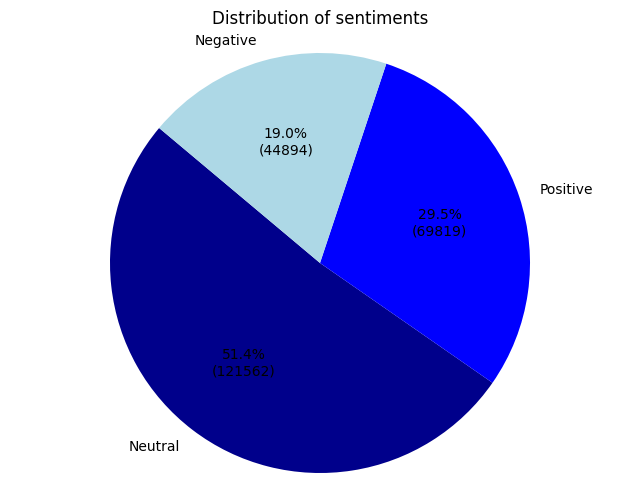

In [11]:
label_counts = df_data['sentiment'].value_counts()

# Plot a pie chart
labels = ['Neutral', 'Positive', 'Negative']
sizes = label_counts.values
colors = ['darkblue', 'blue', 'lightblue']
explode = (0, 0, 0)  # explode 1st slice

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p/100 * sum(sizes)), startangle=140)
plt.axis('equal')
plt.title('Distribution of sentiments')
plt.show()


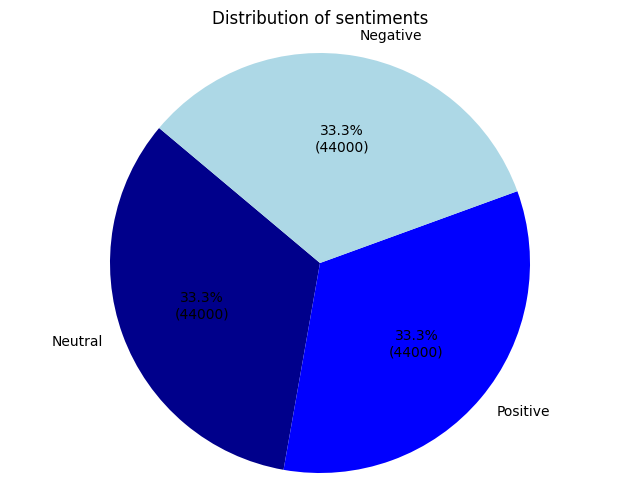

In [12]:
label_counts = df_adjusted['sentiment'].value_counts()

# Plot a pie chart
labels = ['Neutral', 'Positive', 'Negative']
sizes = label_counts.values
colors = ['darkblue', 'blue', 'lightblue']
explode = (0, 0, 0)  # explode 1st slice

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p/100 * sum(sizes)), startangle=140)
plt.axis('equal')
plt.title('Distribution of sentiments')
plt.show()


In [13]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'one', 'two','more','chatgpt','chat','gpt','gpt4','username','chatbot','course','ai','openai'])

In [14]:
def preprocess(text):
    text = text.lower()
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words and word.lower() != 'more']
    return ' '.join(filtered_words)

In [15]:
df_adjusted['clean'] = df_adjusted['text'].apply(preprocess)

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_adjusted['clean'])
sequences = tokenizer.texts_to_sequences(df_adjusted['clean'])
maxlen = 40
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')



In [17]:
embedding_dim = 100
glove_file_path = '/content/glove.6B.100d.txt'

# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Loaded {len(embeddings_index)} word vectors.')

Loaded 400000 word vectors.


In [18]:
word_embedding

NameError: ignored

In [19]:
word_index = tokenizer.word_index
num_words = min(len(word_index) + 1, len(embeddings_index))
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [20]:
# Split data into train and test sets 80:20
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, df_adjusted['sentiment'], test_size=0.2)


In [21]:
# Further splitting the testing data into 50% for testing and 50% for validation
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

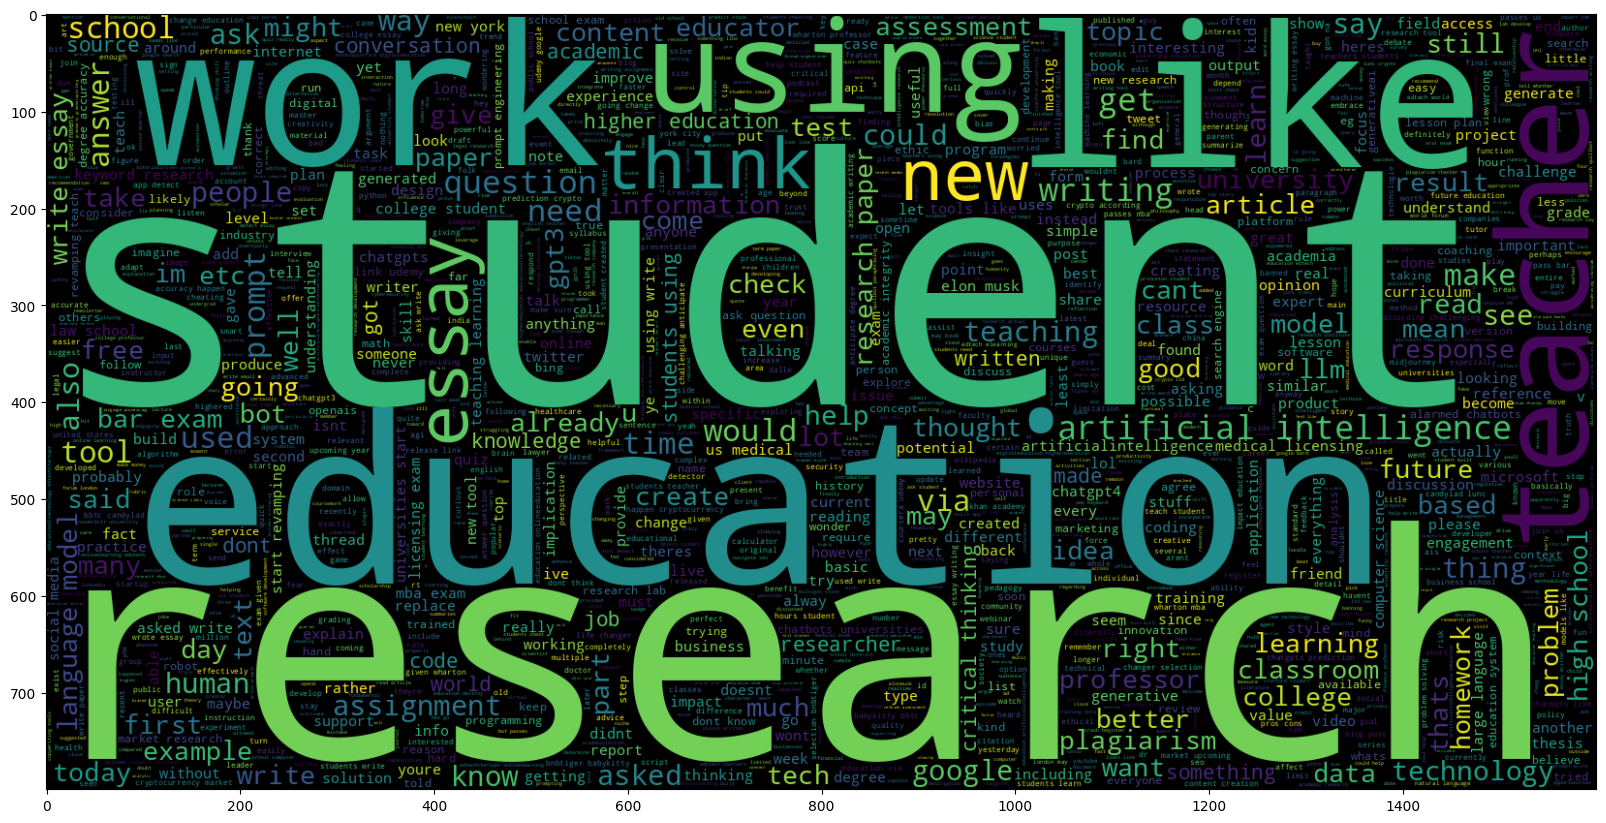

In [22]:
#Neutral sentiment
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df_adjusted[df_adjusted.sentiment==0].clean))
plt.imshow(wc, interpolation = 'bilinear')

In [23]:
# Generate the WordCloud
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(" ".join(df_adjusted[df_adjusted.sentiment == 0].clean))

# Get the top 10 words and their frequencies
top_words = wc.words_
top_words_sorted = sorted(top_words.items(), key=lambda item: item[1], reverse=True)
top_10_words_neutral = [word for word, freq in top_words_sorted[:10]]

print(", ".join(top_10_words_neutral))

student, research, education, like, work, using, teacher, think, essay, new


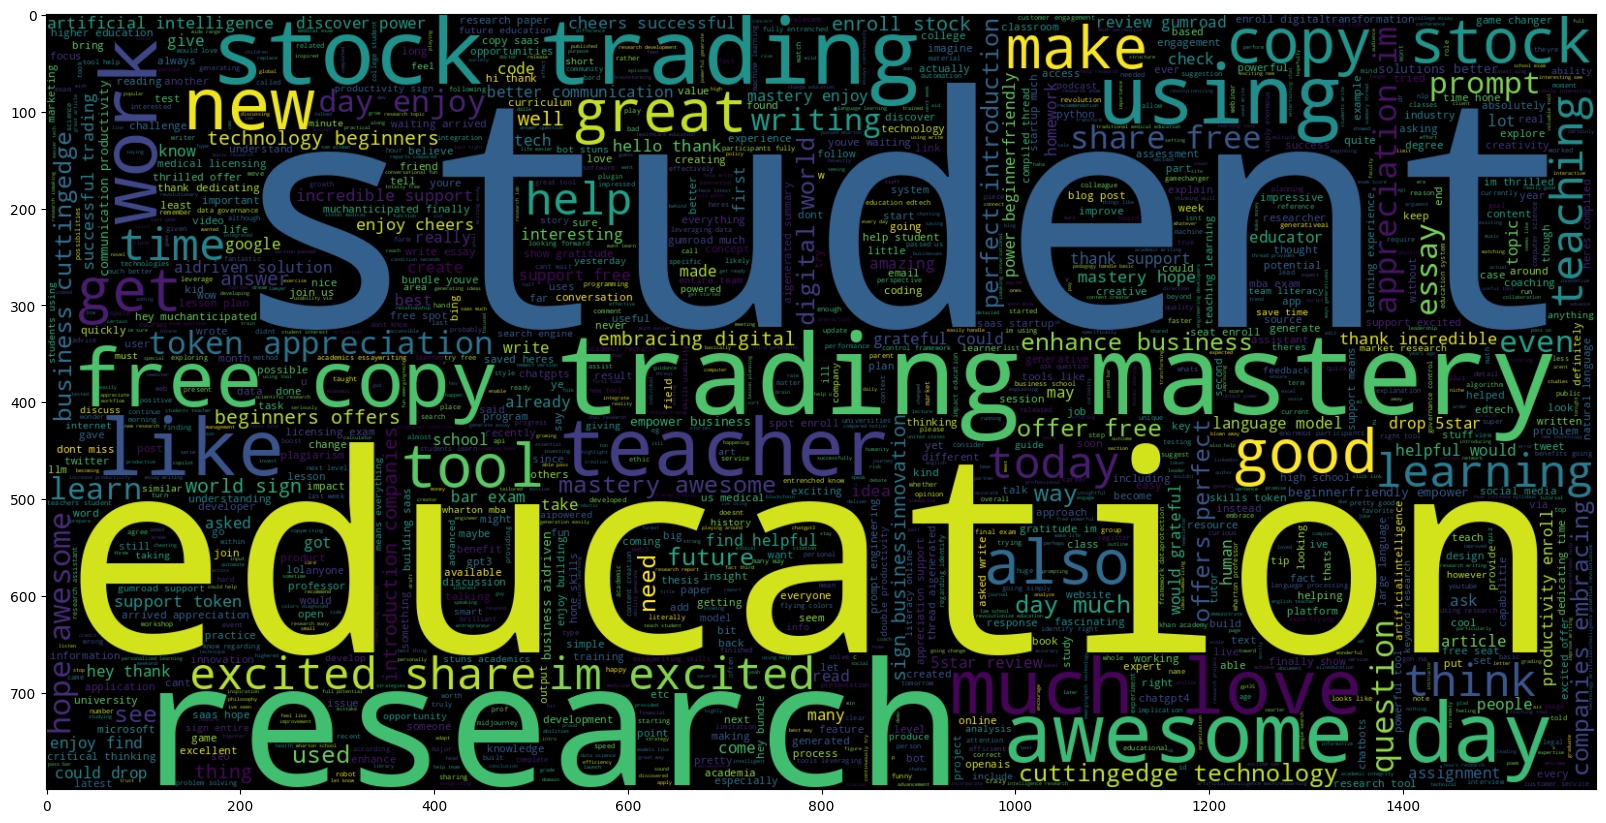

In [24]:
#positive sntiment
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df_adjusted[df_adjusted.sentiment==1].clean))
plt.imshow(wc, interpolation = 'bilinear')

In [25]:
# Generate the WordCloud
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(" ".join(df_adjusted[df_adjusted.sentiment == 1].clean))

# Get the top 10 words and their frequencies
top_words = wc.words_
top_words_sorted = sorted(top_words.items(), key=lambda item: item[1], reverse=True)
top_10_words_positive = [word for word, freq in top_words_sorted[:10]]

print(", ".join(top_10_words_positive))

student, education, research, trading mastery, stock trading, awesome day, using, teacher, free copy, like


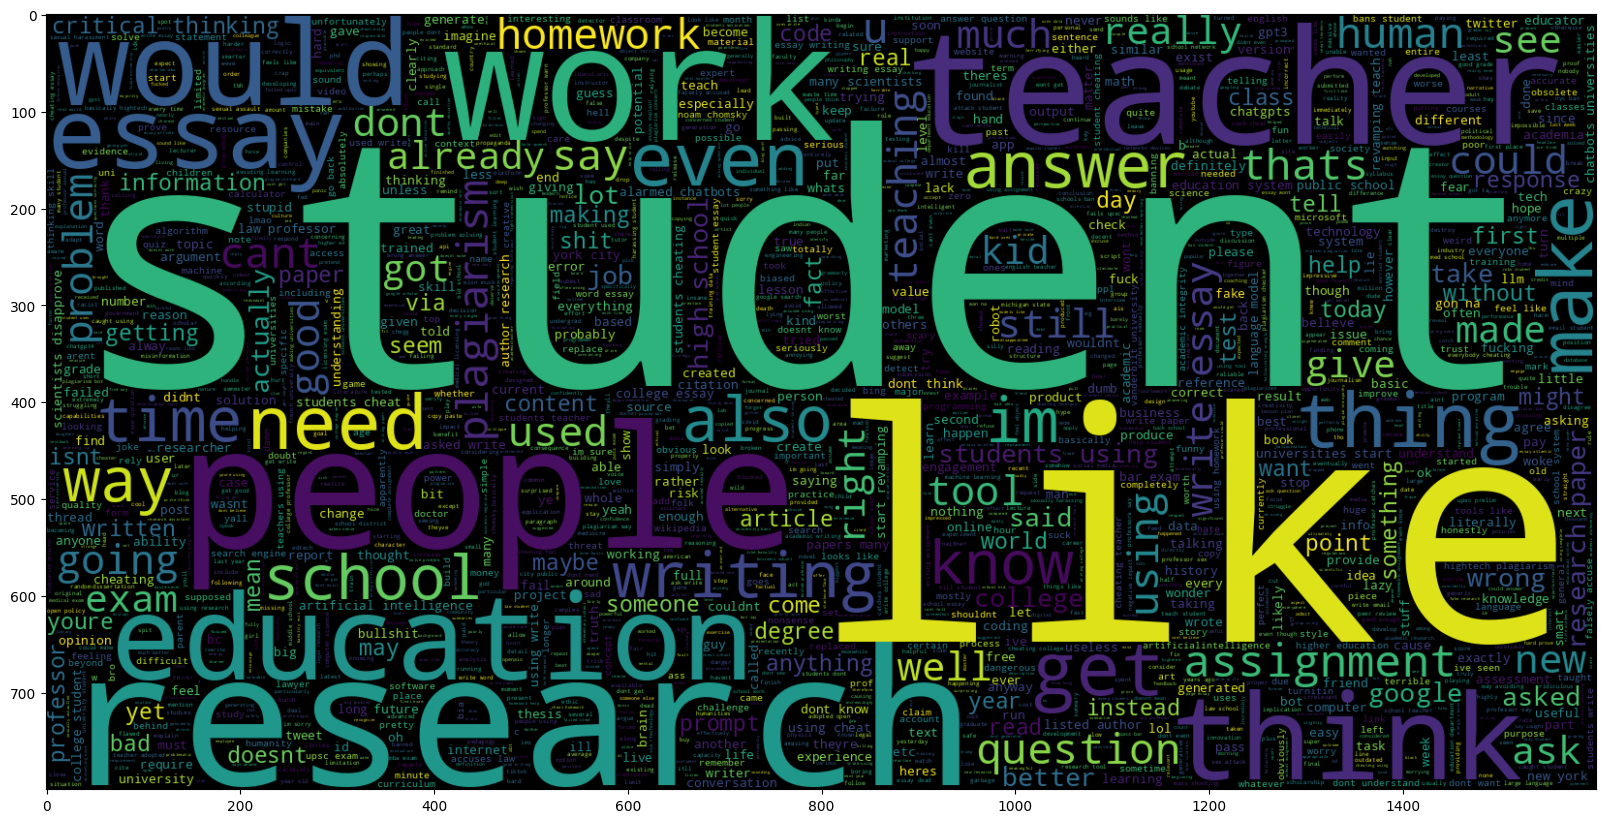

In [28]:
#negative sntiment
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df_adjusted[df_adjusted.sentiment==2].clean))
plt.imshow(wc, interpolation = 'bilinear')

In [30]:
# Generate the WordCloud
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(" ".join(df_adjusted[df_adjusted.sentiment == 2].clean))

# Get the top 10 words and their frequencies
top_words = wc.words_
top_words_sorted = sorted(top_words.items(), key=lambda item: item[1], reverse=True)
top_10_words_positive = [word for word, freq in top_words_sorted[:10]]

print(", ".join(top_10_words_positive))

student, like, research, people, work, teacher, education, think, would, essay


In [32]:
# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_adjusted['clean'])
sequences = tokenizer.texts_to_sequences(df_adjusted['clean'])
maxlen = 40

# Padding the sequences
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

embedding_dim = 100
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [49]:
# Split data into train and test sets 80:20
x_train, x_test, y_train, y_test = train_test_split(padded_sequences,df_adjusted['sentiment'], test_size=0.2)

In [36]:
# Create a multi-class LSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 100)           8129600   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 8,364,867
Trainable params: 235,267
Non-trainable params: 8,129,600
_________________________________________________________________


In [50]:
# Train the model
history = model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=10)


Epoch 1/10
1320/1320 [==============================] - 258s 195ms/step - loss: 0.5153 - acc: 0.7831 - val_loss: 0.5175 - val_acc: 0.7848
Epoch 2/10
1320/1320 [==============================] - 273s 207ms/step - loss: 0.4726 - acc: 0.8045 - val_loss: 0.5169 - val_acc: 0.7828
Epoch 3/10
1320/1320 [==============================] - 281s 213ms/step - loss: 0.4282 - acc: 0.8249 - val_loss: 0.5259 - val_acc: 0.7819
Epoch 4/10
1320/1320 [==============================] - 290s 219ms/step - loss: 0.3808 - acc: 0.8474 - val_loss: 0.5506 - val_acc: 0.7785
Epoch 5/10
1320/1320 [==============================] - 283s 215ms/step - loss: 0.3322 - acc: 0.8679 - val_loss: 0.5911 - val_acc: 0.7681
Epoch 6/10
1320/1320 [==============================] - 281s 213ms/step - loss: 0.2857 - acc: 0.8891 - val_loss: 0.6442 - val_acc: 0.7663
Epoch 7/10
1320/1320 [==============================] - 287s 217ms/step - loss: 0.2415 - acc: 0.9080 - val_loss: 0.6823 - val_acc: 0.7640
Epoch 8/10
1320/1320 [============

825/825 [==============================] - 43s 52ms/step
Model Accuracy: 0.755530303030303
Classification Report:
               precision    recall  f1-score   support

     neutral       0.69      0.69      0.69      8739
    positive       0.80      0.78      0.79      8819
    negative       0.77      0.80      0.78      8842

    accuracy                           0.76     26400
   macro avg       0.76      0.76      0.76     26400
weighted avg       0.76      0.76      0.76     26400



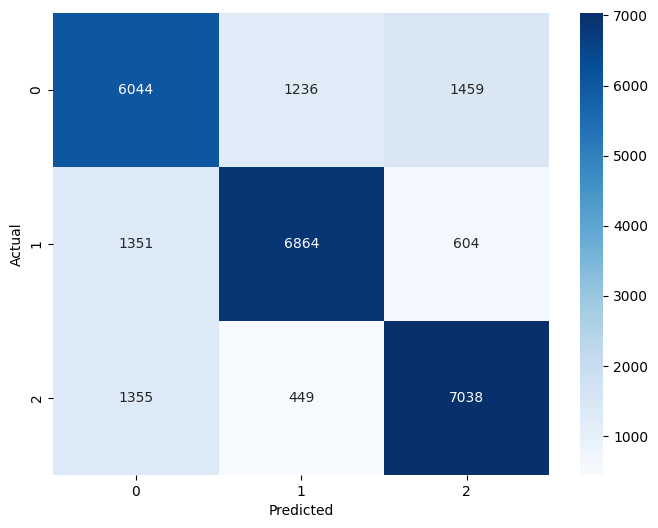

In [51]:
# Classification and Evaluation 80:20
predictions = model.predict(x_test)
classification = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_test, classification)
print("Model Accuracy:", accuracy)

report = classification_report(y_test, classification, target_names=["neutral", "positive", "negative"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test, classification)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [52]:
# Split data into train and test sets 90:10
x_train, x_test, y_train, y_test = train_test_split(padded_sequences,df_adjusted['sentiment'], test_size=0.9)

3713/3713 [==============================] - 187s 50ms/step
Model Accuracy: 0.893442760942761
Classification Report:
               precision    recall  f1-score   support

     neutral       0.87      0.86      0.86     39690
    positive       0.92      0.91      0.91     39607
    negative       0.90      0.91      0.91     39503

    accuracy                           0.89    118800
   macro avg       0.89      0.89      0.89    118800
weighted avg       0.89      0.89      0.89    118800



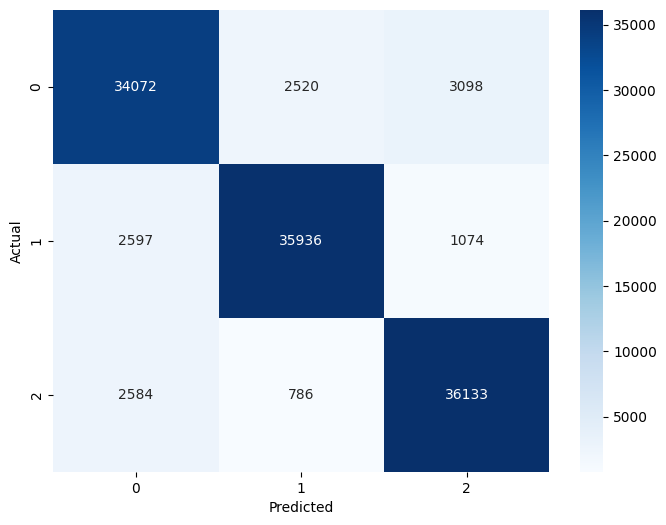

In [53]:
# Classification and Evaluation
predictions = model.predict(x_test)
classification = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_test, classification)
print("Model Accuracy:", accuracy)

report = classification_report(y_test, classification, target_names=["neutral", "positive", "negative"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test, classification)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [54]:
# Split data into train and test sets 50:50
x_train, x_test, y_train, y_test = train_test_split(padded_sequences,df_adjusted['sentiment'], test_size=0.5)

2063/2063 [==============================] - 108s 52ms/step
Model Accuracy: 0.8933636363636364
Classification Report:
               precision    recall  f1-score   support

     neutral       0.87      0.86      0.86     22138
    positive       0.91      0.91      0.91     21949
    negative       0.90      0.92      0.91     21913

    accuracy                           0.89     66000
   macro avg       0.89      0.89      0.89     66000
weighted avg       0.89      0.89      0.89     66000



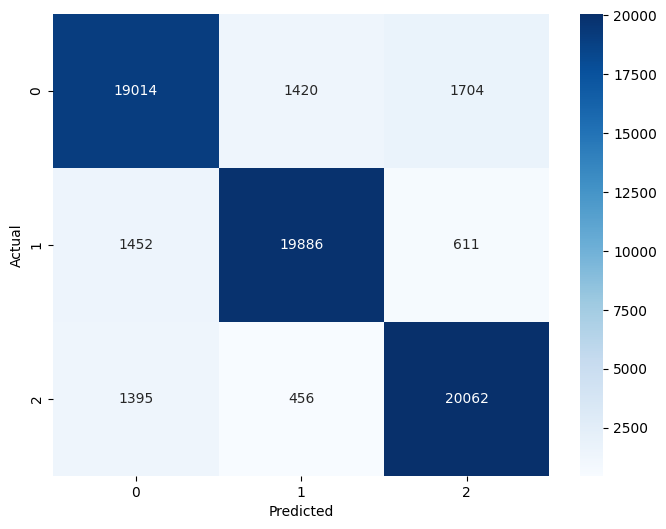

In [55]:
# Classification and Evaluation
predictions = model.predict(x_test)
classification = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_test, classification)
print("Model Accuracy:", accuracy)

report = classification_report(y_test, classification, target_names=["neutral", "positive", "negative"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test, classification)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


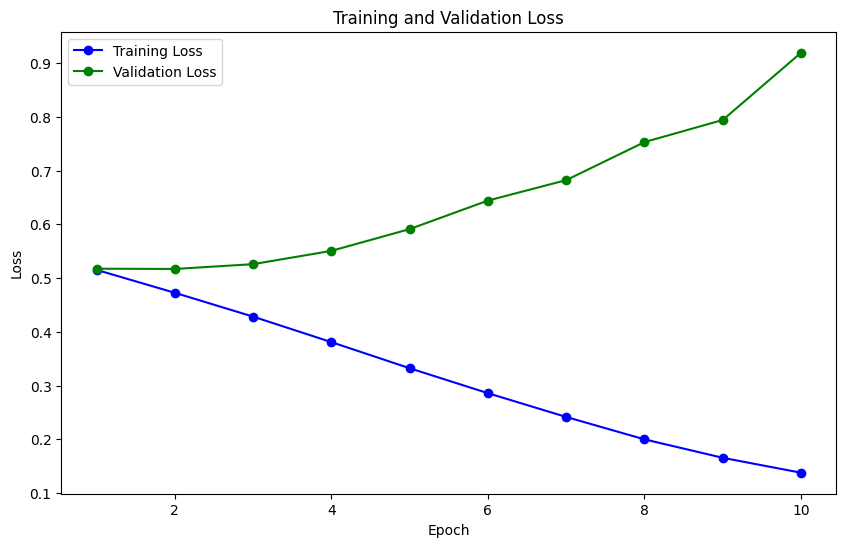

In [56]:
# Get the training and validation loss from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [57]:
# Split data into train and test sets 60:40
x_train, x_test, y_train, y_test = train_test_split(padded_sequences,df_adjusted['sentiment'], test_size=0.4)

1650/1650 [==============================] - 87s 53ms/step
Model Accuracy: 0.8940719696969697
Classification Report:
               precision    recall  f1-score   support

     neutral       0.87      0.86      0.86     17605
    positive       0.92      0.91      0.91     17604
    negative       0.90      0.91      0.91     17591

    accuracy                           0.89     52800
   macro avg       0.89      0.89      0.89     52800
weighted avg       0.89      0.89      0.89     52800



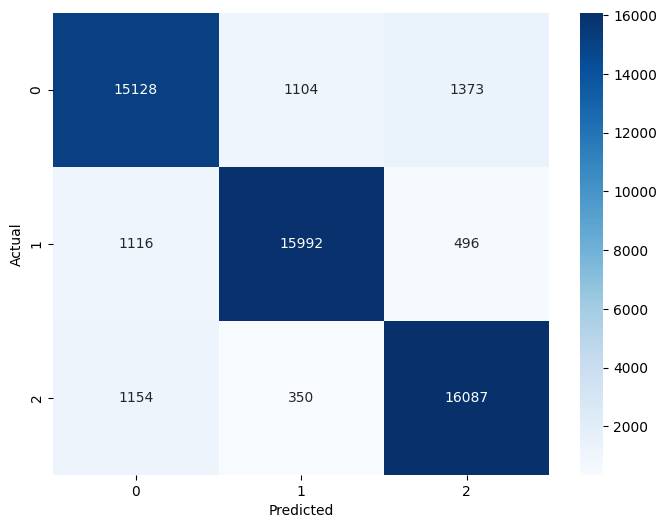

In [58]:
# Classification and Evaluation
predictions = model.predict(x_test)
classification = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_test, classification)
print("Model Accuracy:", accuracy)

report = classification_report(y_test, classification, target_names=["neutral", "positive", "negative"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test, classification)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [59]:
# Split data into train and test sets 70:30
x_train, x_test, y_train, y_test = train_test_split(padded_sequences,df_adjusted['sentiment'], test_size=0.3)

1238/1238 [==============================] - 68s 55ms/step
Model Accuracy: 0.8939141414141414
Classification Report:
               precision    recall  f1-score   support

     neutral       0.87      0.86      0.86     13278
    positive       0.92      0.91      0.91     13088
    negative       0.90      0.91      0.91     13234

    accuracy                           0.89     39600
   macro avg       0.89      0.89      0.89     39600
weighted avg       0.89      0.89      0.89     39600



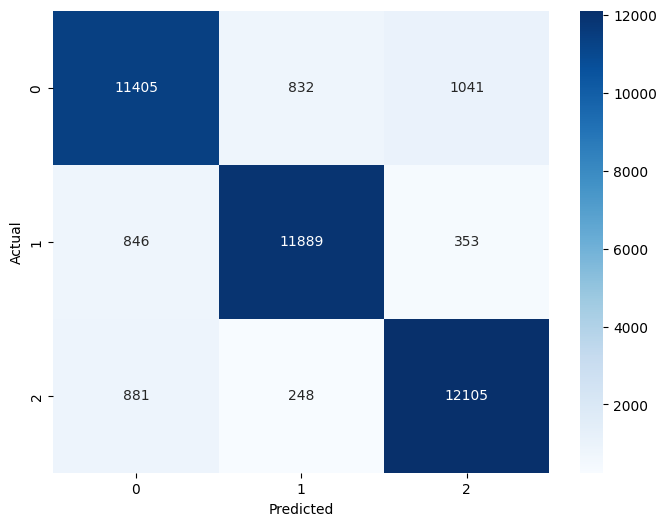

In [60]:
# Classification and Evaluation
predictions = model.predict(x_test)
classification = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_test, classification)
print("Model Accuracy:", accuracy)

report = classification_report(y_test, classification, target_names=["neutral", "positive", "negative"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test, classification)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
